In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ab-testing/ab_data.csv


In [33]:
import scipy.stats as stats

## Data Cleaning & Exploration

In [34]:
df= pd.read_csv('/kaggle/input/ab-testing/ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [35]:
df.shape

(294478, 5)

In [36]:
df.duplicated().sum()

0

In [37]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [38]:
multi= df.user_id.value_counts(ascending=False)
multi_users = multi[multi > 1].count()
print(multi_users)
print((multi_users/df.shape[0])*100)

3894
1.3223398691922656


There are 3894 users with more than 1 session. We will remove them as they comprise of around 1% of the total sessions

In [39]:

df = df[~df['user_id'].isin( multi[multi > 1].index)]
print(df.shape)

(286690, 5)


In [40]:
ct = pd.crosstab(df['group'], df['converted'], normalize='index') * 100
print(ct)

converted          0          1
group                          
control    87.982665  12.017335
treatment  88.127367  11.872633


In [41]:
control = df[df['group'] == 'control']
treatment = df[df['group'] == 'treatment']
control_signups = control['converted'].mean()
treatment_signups = treatment['converted'].mean()
print(f" The percentage of avg. conversion for control signups:{round(control_signups,2)}%")
print(f" The percentage of avg. conversion for treatment signups:{round(treatment_signups,2)}%")


 The percentage of avg. conversion for control signups:0.12%
 The percentage of avg. conversion for treatment signups:0.12%


The precision of our estimated conversion rates is affected by the number of people (or user sessions) we choose to include in each group. Larger sample sizes lead to more precise estimates, with smaller confidence intervals, and a higher likelihood of detecting any differences between the two groups, if there are any.

However, as the sample size increases, the study becomes more costly and impractical. Hence, determining the appropriate sample size for each group is crucial.

We estimate the required sample size using power analysis, which depends on several factors, including the power of the test, the alpha value, and the effect size - how much of a difference we anticipate between the conversion rates.

Assuming that there will be a satistifaction with a 3% difference, we can use 12% and 15% to determine the expected effect size.

In [55]:
import statsmodels.stats.api as sms
from math import ceil

effect_size = sms.proportion_effectsize(0.12, 0.15)    

sample_size = sms.NormalIndPower().solve_power(
    effect_size, 
    power=0.90, 
    alpha=0.05, 
    ratio=1
    )                                                  
sample_size = ceil(sample_size)                                                 

print(f" We will need a sample size of {sample_size} for each group")

 We will need a sample size of 2719 for each group


In [56]:
control_group = df[df['group'] == 'control'].sample(n=sample_size, random_state=45)
treatment_group = df[df['group'] == 'treatment'].sample(n=sample_size, random_state=45)

test_df = pd.concat([control_group, treatment_group], axis=0)
test_df.reset_index(drop=True, inplace=True)

In [57]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5438 entries, 0 to 5437
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_id       5438 non-null   int64 
 1   timestamp     5438 non-null   object
 2   group         5438 non-null   object
 3   landing_page  5438 non-null   object
 4   converted     5438 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 212.5+ KB


In [58]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
control_results = test_df[test_df['group'] == 'control']['converted']
treatment_results = test_df[test_df['group'] == 'treatment']['converted']

## Testing Normality Assumption

Wilks test is a way to test if the serie has normal distribution or not.  According to result of the test it can be decided between Independent Samples t Test and Mann-Whitney U Test.

If p value of the test is less than .05, the A/B Testing method will be Mann-Whitney U Test. p <= alpha: reject H0, not normal. * p > alpha: fail to reject H0, normal Gaussian distribution

In [59]:
w, p = stats.shapiro(control_results)
w, p

(0.37358617782592773, 0.0)

In [60]:
alpha = .05
p < alpha

True

In [61]:
w, p = stats.shapiro(treatment_results)
w, p
alpha = .05
p < alpha

True

Normality assumptions are violated so we will use the non parametric test


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  """


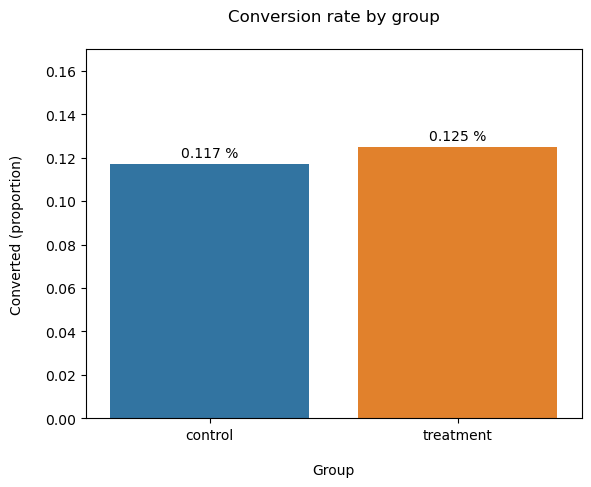

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns


ax = sns.barplot(x=test_df['group'], y=test_df['converted'], ci=False)
plt.ylim(0, 0.17)

plt.title('Conversion rate by group', pad=20)
plt.xlabel('Group', labelpad=15)
plt.ylabel('Converted (proportion)', labelpad=15)

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f"{height:.3f} %", xy=(p.get_x() + p.get_width() / 2, height),
                xytext=(0, 5), textcoords='offset points', ha='center')


## Mann-Whitney U Test

The treatment group was seen to have a higher mean conversion rate. Now we will conduct a statistical test to answer if this difference is statistically significant

In [63]:
from scipy.stats import  mannwhitneyu


In [64]:
statistic, pvalue = mannwhitneyu(control_results, treatment_results, alternative='two-sided')


In [65]:
# print the results
print('Mann-Whitney U test results:')
print('Statistic =', statistic)
print('p-value =', pvalue)

# check for significance at the 5% level
if pvalue < 0.05:
    print('The difference between control and treatment groups is statistically significant.')
else:
    print('The difference between control and treatment groups is not statistically significant.')

Mann-Whitney U test results:
Statistic = 3667931.0
p-value = 0.3822959379178349
The difference between control and treatment groups is not statistically significant.


## AB Test Results

The Mann-Whitney U test was conducted to determine if there is a significant difference between the conversion rates of a control group and a treatment group. The test result showed a statistic of 3667931.0 and a p-value of 0.3822959379178349. Since the p-value is greater than the significance level of 0.05, we fail to reject the null hypothesis and conclude that there is no statistically significant difference in conversion rates between the control group and the treatment group. Therefore, we cannot say that the new landing page has a significant effect on the conversion rate compared to the old landing page.